# Implementación de una red AC-GAN con Keras<a id="top"></a>

<i><small>Autor: Algigantix<br>Última actualización: 2023-04-28</small></i></div>

## Introducción

Las redes generativas adversariales (GAN, de _Generative Adversarial Networks_) fueron presentadas por primera vez por Goodfellow et al. en el artículo [Generative Adversarial Networks](https://arxiv.org/abs/1406.2661) publicado en 2014. Este tipo de redes pueden ser utilizadas para la generación sintética de datos prácticamente idénticos a los originales.

Para la generación de estos datos se usan dos redes neuronales durante el entrenamiento: la **generadora**, que acepta un vector de entrada de ruido generado aleatoriamente y produce los datos de salida de aspecto similar a los datos auténticos, y la **discriminadora**, que intenta determinar si los datos que se le presentan son auténticos o generados.

Entrenando estas redes al mismo tiempo, una retroalimentando a la otra, dispondremos de un medio para generar datos prácticamente indistinguibles de los originales, o visto de otro modo, dispondremos de un medio para determinar si unos determinados datos son verdaderos o _fake_.

Una AC-GAN (_Auxiliary Classifier GAN_) es una variante en la que se incluye la clasificación por clases en la entrada de las dos redes, y la red discriminadora puede clasificar según probabilidad de que una imagen sea de una clase u  otra. Además emplean redes de convolución.

En nuestro caso, diseñaremos una red ACGAN que trate de replicar caracteres escritos.

## Imports y configuración

Primero importamos las bibliotecas que necesitamos:
* emnist: la base de datos con números y letras
* enum: por definir las clases como una enumeración.
* tensorflow y keras: para lo relacionado con Redes de Neuronas (capas, optimizadores, algunos gráficos, modelos y guardar y cargar modelos).
* math: algunas funciones matemáticas.
* matplotlib.pyplot: elementos gráficos.
* numpy algunas operaciones sobre matrices, incluidas matrices aleatorias para el ruido.

Para facilitarnos la vida hemos decidido importar las capas directamente para no añadir un montón de texto.

In [77]:
#import collections # sería por el deque

from emnist import extract_training_samples
from emnist import extract_test_samples

import enum

import tensorflow as tf

from keras.initializers import RandomNormal

from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.layers import Concatenate
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Flatten
from keras.layers import Input
from keras.layers import LeakyReLU
from keras.layers import Reshape

from keras.models import Model
from keras.models import load_model

from keras.optimizers import Adam

from keras.utils.vis_utils import plot_model

from math import sqrt

import matplotlib.pyplot as plt

#import numpy as np
from numpy import asarray
from numpy import ones
from numpy import zeros
from numpy import expand_dims
from numpy.random import randn
from numpy.random import randint

También incluimos un pip por si faltan algunos paquetes en la instalación

In [12]:
!pip install pydot

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [74]:
!pip install emnist

Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 0.0/77.1 kB ? eta -:--:--
     ---------------------------------------- 77.1/77.1 kB 4.5 MB/s eta 0:00:00


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Asimismo algunas configuraciones gráficas.

In [4]:
%matplotlib notebook
plt.style.use('ggplot')
plt.rcParams.update({'figure.figsize': (15, 8),'figure.dpi': 64})

## El dataset que usaremos

Utilizaremos un dataset de emnist, que tiene más datos que el de mnist. En este caso el "balanced", que tiene 47 clases de caracteres.

Como se dice en [este estudio](https://arxiv.org/pdf/1610.09585.pdf), una mayor resolución ayuda en la discriminación,  pero para este caso 28x28 es más que suficiente.

In [121]:
WIDTH, HEIGHT, CHANNELS = 28, 28, 1

Train (112800, 28, 28) (112800,)
Test (18800, 28, 28) (18800,)


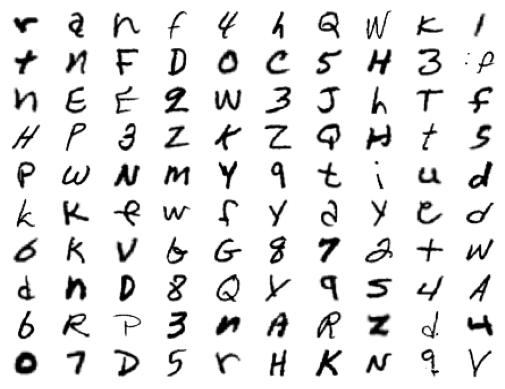

LINE 
45 36 43 15 4 42 26 32 20 1 LINE 
46 43 15 13 24 12 5 17 3 40 LINE 
42 14 14 44 32 3 19 42 29 40 LINE 
17 25 3 35 20 35 26 17 46 28 LINE 
25 32 23 22 34 9 46 19 30 38 LINE 
20 20 15 32 40 34 36 34 39 38 LINE 
37 20 31 16 16 44 7 2 46 32 LINE 
38 43 13 8 26 34 44 28 4 10 LINE 
6 27 25 3 43 10 27 35 38 4 LINE 
24 7 13 5 45 17 20 23 44 31 

In [81]:
# Cargamos las imágenes en la memoria

(trainX, trainy) = extract_training_samples('balanced')
(testX, testy) = extract_test_samples('balanced')

#(trainX, trainy), (testX, testy) = tf.keras.datasets.mnist.load_data()#load_data()
print('Train', trainX.shape, trainy.shape)
print('Test', testX.shape, testy.shape)

# Pintamos algunas imágenes para ver que se han cargado
for i in range(100):
 # define subplot
 plt.subplot(10, 10, 1 + i)
 # turn off axis
 plt.axis('off')
 # plot raw pixel data
 plt.imshow(trainX[i], cmap='gray_r')
plt.show()
for i in range(100):
    if i%10 == 0:
        print("LINE ")
    print(trainy[i], end= " ")


In [114]:
# Nos aseguramos que el máximo es el que dice ser
def masAlto(trainy):
    max = -1
    for i in range(len(trainy)):
        if trainy[i] > max:
            max = trainy[i]
    print(max)
    
masAlto(trainy)

46


In [90]:
# Una función auxiliar, que hemos utilizado para buscar letras y asegurarnos de que son lo que dicen ser
def buscar(trainy, buscado):
    enc = 0
    for i in range(len(trainy)):
        if trainy[i] == buscado:
            plt.imshow(trainX[i], cmap='gray_r')
            plt.show()
            enc+=1
            if enc == 2:
                return 0

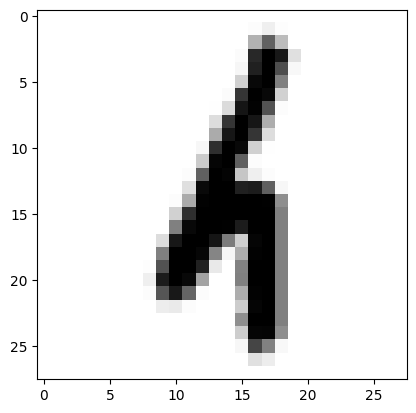

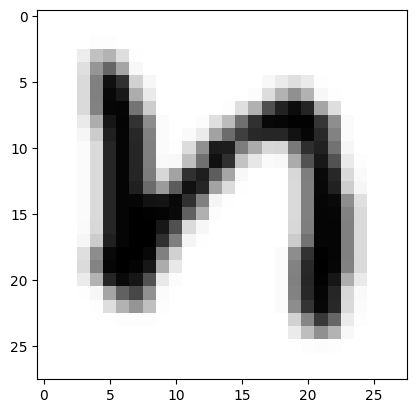

0

In [100]:
buscar(trainy, 42)

También definiremos las clases de letras y números, por claridad. Nótese que algunos caracteres están repetidos puesto que la base de datos los considera demasiado difíciles de distinguir.

In [101]:
class LosCaracteres(enum.Enum):
    """Cada una de los posibles caracteres."""
    cero = 0
    uno = 1
    dos = 2
    tres = 3
    cuatro = 4
    cinco = 5
    seis =  6
    siete = 7
    ocho = 8
    nueve = 9
    A = 10
    B = 11
    C = 12
    D = 13
    E = 14
    F = 15
    G = 16
    H = 17
    I = 18
    J = 19
    K = 20
    L = 21
    M = 22
    N = 23
    O = 24
    P = 25
    Q = 26
    R = 27
    S = 28
    T = 29
    U = 30
    V = 31
    W = 32
    X = 33
    Y = 34
    Z = 35
    a = 36
    b = 37
    c = 12
    d = 38
    e = 39
    f = 40
    g = 41
    h = 42
    i = 18
    j = 19
    k = 20
    l = 21
    m = 22
    n = 43
    o = 24
    p = 25
    q = 44
    r = 45
    s = 28
    t = 46
    u = 30
    v = 31
    w = 32
    x = 33
    y = 34
    z = 35



In [102]:
num_clases = 47

## Red generadora

La parte generadora de un modelo ACGAN se encarga de generar datos nuevos a partir de ruido aleatorio y una clase. Es de esperar que, a la larga, sea capaz de generar nuevos datos con una distribución similar a la de los elementos reales.

Y ya que hemos dicho _ruido aleatorio_, vamos con la definición de la longitud del vector de valores de entrada de ruido. Se puede hacer como hace el profesor, o bien definirla como una dimensión latente. Nosotros elegimos 100 por pura conveniencia.

In [106]:
# define the size of the latent space
latent_dim = 100

Por otra parte la clase específica puede definirse por codificación one-hot, o bien como un canal adicional al comienzo. El estudio dado utiliza one-hot de 10 valores, pero actualmente se recomienda generalmente la última opción, que se puede realizar con un Embedding que luego entre en una capa Dense y genere una "imagen" o mapa extra.

En cuanto a la generación de la imagen, se puede codificar de tal forma que una vez se fusionan la clase y ruido, genere una pequeña imagen que luego se le aplica deconvolución para aumentar su tamaño al de las muestras de nuestro dataset (en este caso, 28x28).

Utilizamos Batch normalization para prevenir problemas por gradientes. Se podría haber utilizado dropout pero en este caso nos interesa que el generador siempre empiece a entrenar mejor que el discriminador, y Batch tiene la ventaja de que normaliza tanto en entrenamiento como al inferir para datos similares.

In [117]:
def define_generator(latent_dim, n_classes=10):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # label input
    in_label = Input(shape=(1,))
    # embedding for categorical input
    li = Embedding(n_classes, 50)(in_label)
    # linear multiplication
    n_nodes = 7 * 7
    li = Dense(n_nodes, kernel_initializer=init)(li)
    # reshape to additional channel
    li = Reshape((7, 7, 1))(li)
    # image generator input
    in_lat = Input(shape=(latent_dim,))
    # foundation for 7x7 image
    n_nodes = 384 * 7 * 7
    gen = Dense(n_nodes, activation='relu', kernel_initializer=init)(in_lat)
    #gen = Dense(n_nodes, kernel_initializer=init)(in_lat)
    #gen = Activation('relu')(gen) # TO-DO ver si esto se puede pasar arriba
    gen = Reshape((7, 7, 384))(gen)
    # merge image gen and label input
    merge = Concatenate()([gen, li])
    # upsample to 14x14
    gen = Conv2DTranspose(192, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(merge)
    gen = BatchNormalization()(gen)
    gen = Activation('relu')(gen)
    # upsample to 28x28
    out_layer = Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', activation='tanh', kernel_initializer=init)(gen)
    #gen = Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(gen)
    #out_layer = Activation('tanh')(gen)
    # define model
    model = Model([in_lat, in_label], out_layer, name='Generator')
    return model

Model: "Generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_73 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_74 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 embedding_26 (Embedding)       (None, 1, 50)        2350        ['input_73[0][0]']               
                                                                                                  
 dense_92 (Dense)               (None, 18816)        1900416     ['input_74[0][0]']               
                                                                                          

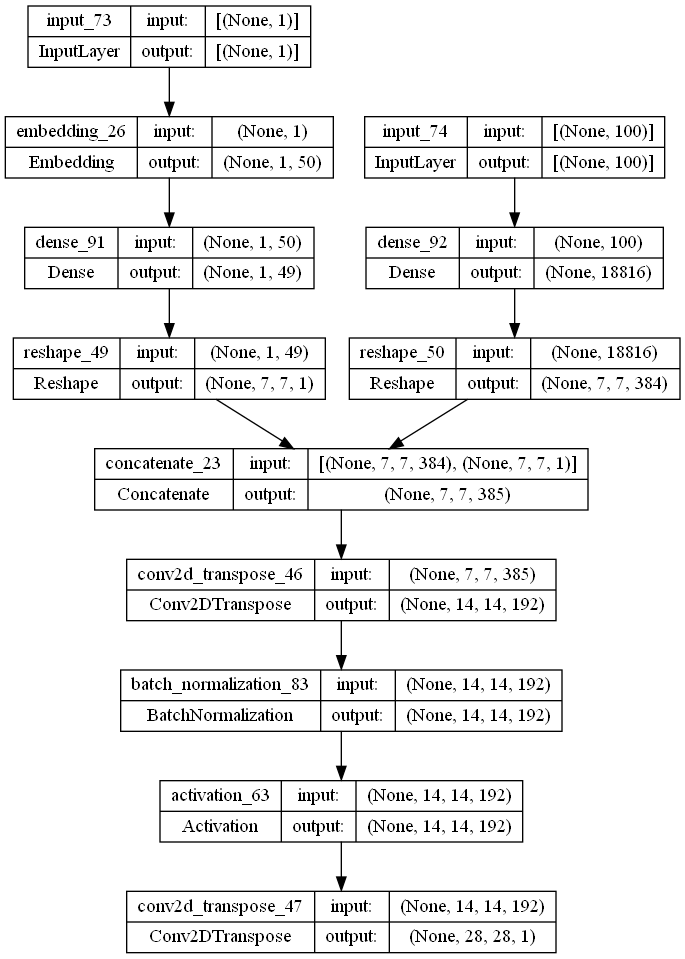

In [118]:
generator = define_generator(latent_dim, num_clases)
# summarize the model
generator.summary()
# plot the model
plot_model(generator, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

## Red discriminadora

Ahora que tenemos el generador, procedemos a crear un discriminador, que en este caso nos dirá no solo si es auténtica o falsa, sino de cuál clase es.

La utilización de dropouts no es solo para reducir el sobreajuste, sino por cómo funciona una GAN, en la que para que se vaya aprendiendo la red competidora debe fallar un poco, porque si una red aprende demasiado rápido entonces la otra no aprende. Como en nuestro caso lo que nos interesa es falsificar letras y números, nos interesa que el discriminador no aprenda demasiado rápido.

Aquí lo que se hace es realizar convolución para realizar las operaciones inversas al generador, de tal forma que se pase de una imagen de 28x28 a una de 7x7 y se aplane para analizar por las dos salidas indicadas, codificadas como capas Dense, en la que una de ellas tiene una sola neurona de salida que devuelve true/false con binary_crossentropy, y la otra devuelve la clase, que en este caso se codifica la salida como one-hot con categorial_crossentropy, porque en este caso una letra solo puede ser una, no varias. El uso de la activación LeakyRelu se utiliza para que aprenda

El Adam se ha ajustado a valores que se han visto funcionan adecuadamente mientras aprende más o menos rápido, según los resultados de artículo.

Model: "Discriminator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_72 (InputLayer)          [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_76 (Conv2D)             (None, 14, 14, 32)   320         ['input_72[0][0]']               
                                                                                                  
 leaky_re_lu_76 (LeakyReLU)     (None, 14, 14, 32)   0           ['conv2d_76[0][0]']              
                                                                                                  
 dropout_76 (Dropout)           (None, 14, 14, 32)   0           ['leaky_re_lu_76[0][0]']         
                                                                                      

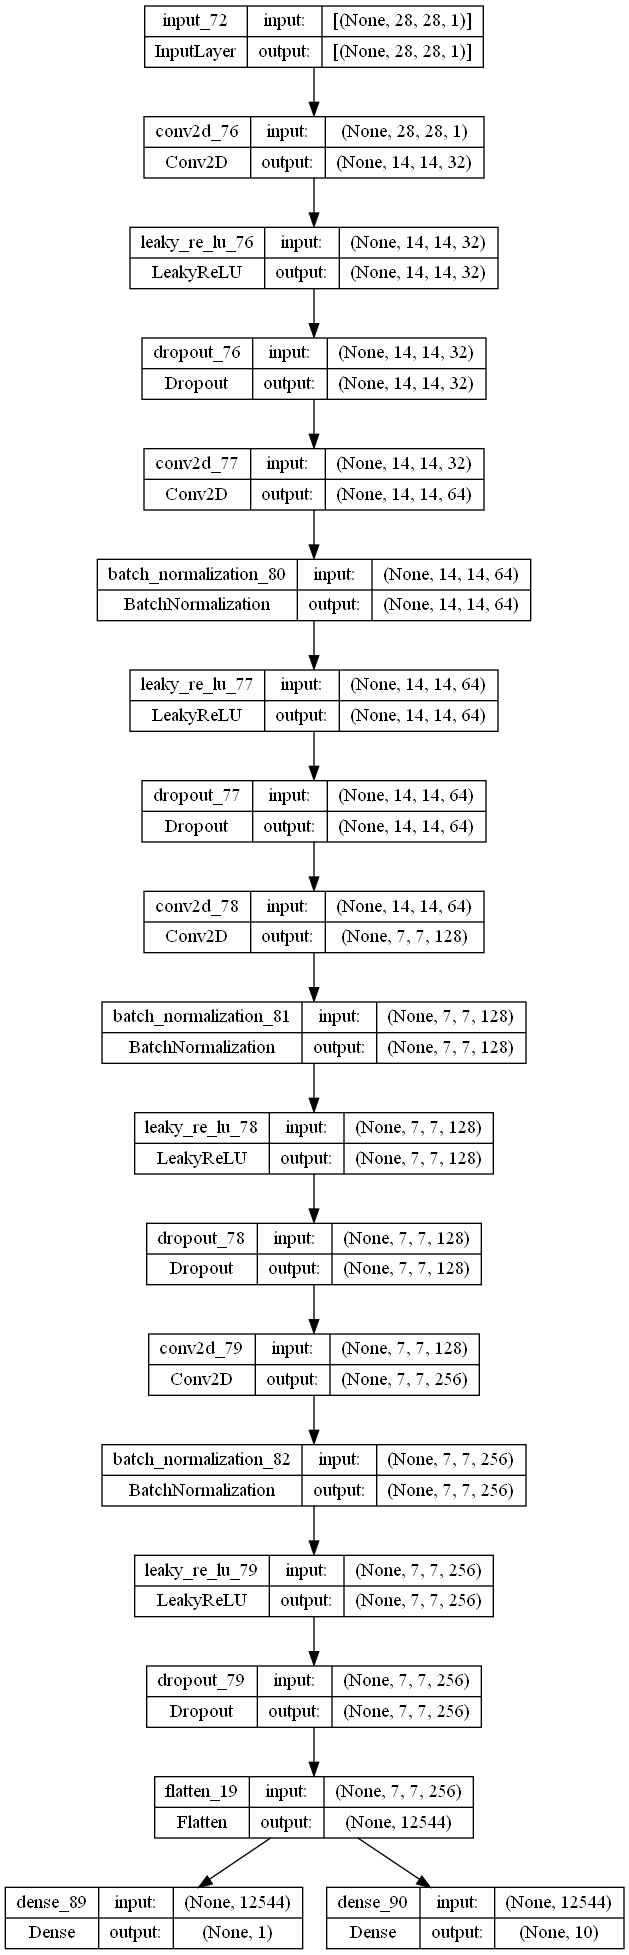

In [115]:
# example of defining the discriminator model
 
# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1), n_classes=10):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image input
    in_image = Input(shape=in_shape)
    # downsample to 14x14
    fe = Conv2D(32, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # normal
    fe = Conv2D(64, (3,3), padding='same', kernel_initializer=init)(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # downsample to 7x7
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # normal
    fe = Conv2D(256, (3,3), padding='same', kernel_initializer=init)(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # flatten feature maps
    fe = Flatten()(fe)
    # real/fake output
    out1 = Dense(1, activation='sigmoid')(fe)
    # class label output
    out2 = Dense(n_classes, activation='softmax')(fe)
    # define model
    model = Model(in_image, [out1, out2], name='Discriminator')
    # compile model
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
    return model

Model: "Discriminator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_75 (InputLayer)          [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_80 (Conv2D)             (None, 14, 14, 32)   320         ['input_75[0][0]']               
                                                                                                  
 leaky_re_lu_80 (LeakyReLU)     (None, 14, 14, 32)   0           ['conv2d_80[0][0]']              
                                                                                                  
 dropout_80 (Dropout)           (None, 14, 14, 32)   0           ['leaky_re_lu_80[0][0]']         
                                                                                      

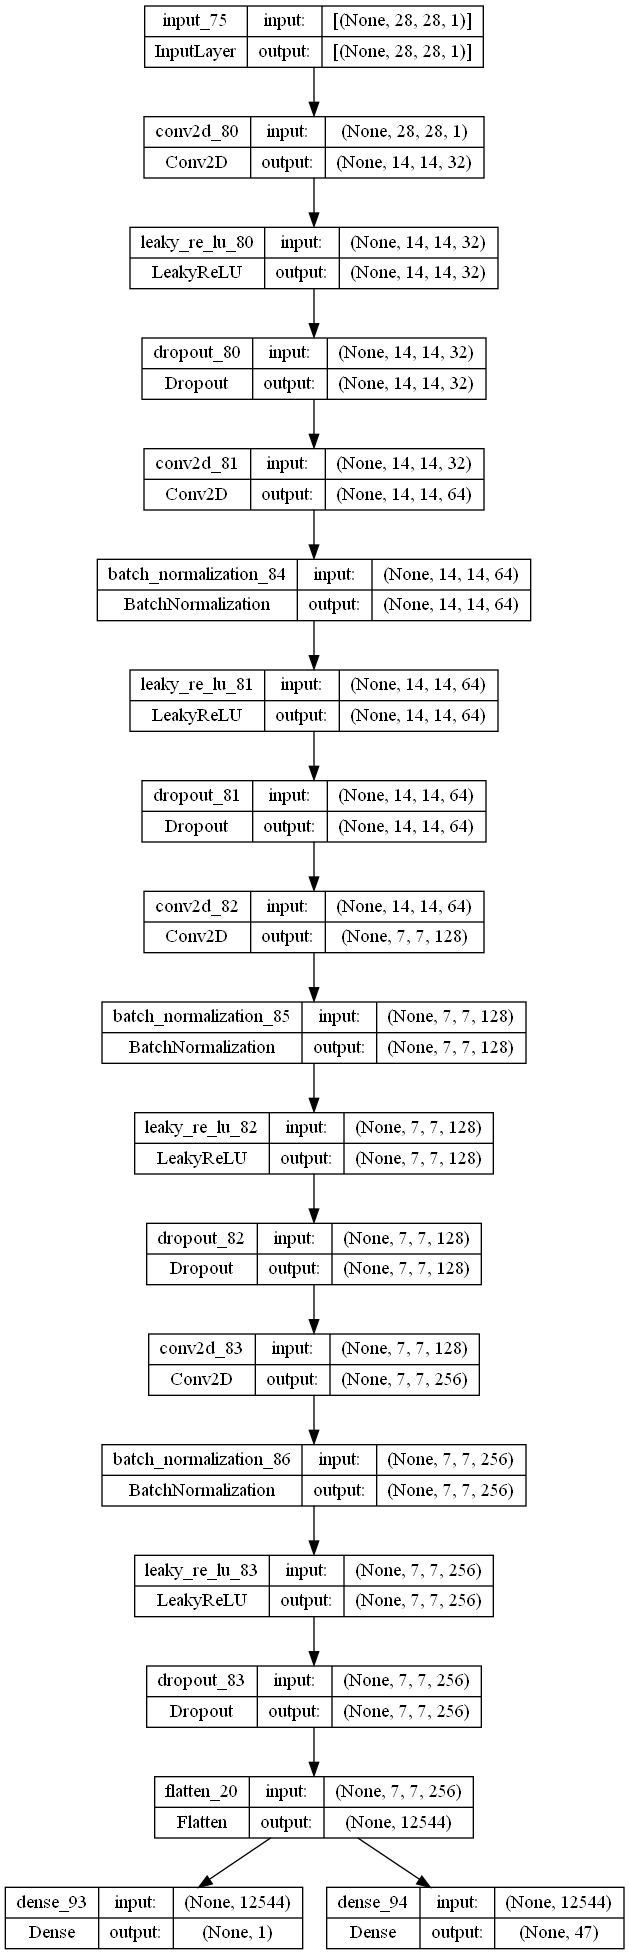

In [123]:
discriminator = define_discriminator(in_shape=(WIDTH, HEIGHT, CHANNELS), n_classes=num_clases)
# summarize the model
discriminator.summary()
# plot the model
plot_model(discriminator, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

## Definición de la arquitectura GAN

Ya disponemos de una red generadora y otra discriminadora. Ahora, antes de realizar la composición del modelo completo, compilaremos el discriminador para luego impedir el entrenamiento de sus pesos en el resto del modelo, solo invocando su grafo explícitamente.

De nuevo ajustamos el Adam del modelo total a los parámetros qque heurísticamente han probado ser los mejores según el artículo.

In [64]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
 # make weights in the discriminator not trainable
 for layer in d_model.layers:
   if not isinstance(layer, BatchNormalization):
     layer.trainable = False
 # connect the outputs of the generator to the inputs of the discriminator
 gan_output = d_model(g_model.output)
 # define gan model as taking noise and label and outputting real/fake and label outputs
 model = Model(g_model.input, gan_output)
 # compile model
 opt = Adam(lr=0.0002, beta_1=0.5)
 model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
 return model

## Entrenamiento del modelo GAN

Ahora sí, podemos proceder al entrenamiento. A modo de resumen, el proceso es el siguiente:

1. Definimos el generador y discriminador, y los unimos en un único modelo.
2. Cargamos datos reales.
3. Entrenamos la red, en un bucle. Antes de todo calculamos el número de batches y pasos a realizar - que son 64 y 100 por defecto, respectivamente.
* 3.1 Tomará medio batch de imágenes reales $\mathcal{R}$, que se indican verdaderas.
* 3.2 Entrenará al discriminador con las muestras auténticas para reconocerlas.
* 3.3 Pedirá al generador crear medio batch de imágenes ficticias $\mathcal{F}$, que se indican adecuadamente como falsas.
* 3.4 Entrenará al discriminador con las muestras falsas para reconocerlas.
* 3.5 Ahora se pedirá al generador crear nuevas muestras falsas $\mathcal{F}$, pero diciendo que son verdaderas.
* 3.6 Se mandan esas muestras a la red GAN entera para entrenarla según el error que de el discriminador - como hemos dicho antes, hemos hecho el discriminador no entrenable cuando está en la GAN así que esto solo entrena al generador.
4. Para hacernos la vida más fácil, cada cierto número de pasos se nos indica como va, y se guarda.

In [65]:
# Cargar imágenes. Para ello es recomendable que pasemos de enteros a flotantes y los normalizemos para prevenir gradientes explosivos.
def load_real_samples():
    # load dataset
    #(trainX, trainy), (_, _) = load_data()
    (trainX, _) = extract_training_samples('balanced')
    (testX, _) = extract_test_samples('balanced')
    # expand to 3d, e.g. add channels
    X = expand_dims(trainX, axis=-1)
    # convert from ints to floats
    X = X.astype('float32')
    # scale from [0,255] to [-1,1]
    X = (X - 127.5) / 127.5
    print(X.shape, trainy.shape)
    return [X, trainy]

In [66]:
# select real samples
def generate_real_samples(dataset, n_samples):
 # split into images and labels
 images, labels = dataset
 # choose random instances
 ix = randint(0, images.shape[0], n_samples)
 # select images and labels
 X, labels = images[ix], labels[ix]
 # generate class labels
 y = ones((n_samples, 1))
 return [X, labels], y

In [67]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
 # generate points in the latent space
 x_input = randn(latent_dim * n_samples)
 # reshape into a batch of inputs for the network
 z_input = x_input.reshape(n_samples, latent_dim)
 # generate labels
 labels = randint(0, n_classes, n_samples)
 return [z_input, labels]

In [68]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
 # generate points in latent space
 z_input, labels_input = generate_latent_points(latent_dim, n_samples)
 # predict outputs
 images = generator.predict([z_input, labels_input])
 # create class labels
 y = zeros((n_samples, 1))
 return [images, labels_input], y

In [69]:
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, latent_dim, n_samples=100):
 # prepare fake examples
 [X, _], _ = generate_fake_samples(g_model, latent_dim, n_samples)
 # scale from [-1,1] to [0,1]
 X = (X + 1) / 2.0
 # plot images
 for i in range(100):
 # define subplot
   plt.subplot(10, 10, 1 + i)
   # turn off axis
   pyplot.axis('off')
   # plot raw pixel data
   plt.imshow(X[i, :, :, 0], cmap='gray_r')
 # save plot to file
 filename1 = 'generated_plot_%04d.png' % (step+1)
 plt.savefig(filename1)
 pyplot.close()
 # save the generator model
 filename2 = 'model_%04d.h5' % (step+1)
 g_model.save(filename2)
 print('>Saved: %s and %s' % (filename1, filename2))

In [70]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=64):
 # calculate the number of batches per training epoch
 bat_per_epo = int(dataset[0].shape[0] / n_batch)
 # calculate the number of training iterations
 n_steps = bat_per_epo * n_epochs
 print(n_steps)
 # calculate the size of half a batch of samples
 half_batch = int(n_batch / 2)
 # manually enumerate epochs
 for i in range(n_steps):
   # get randomly selected 'real' samples
   [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
   # update discriminator model weights
   _,d_r1,d_r2 = d_model.train_on_batch(X_real, [y_real, labels_real])
   # generate 'fake' examples
   [X_fake, labels_fake], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
   # update discriminator model weights
   _,d_f,d_f2 = d_model.train_on_batch(X_fake, [y_fake, labels_fake])
   # prepare points in latent space as input for the generator
   [z_input, z_labels] = generate_latent_points(latent_dim, n_batch)
   # create inverted labels for the fake samples
   y_gan = ones((n_batch, 1))
   # update the generator via the discriminator's error
   _,g_1,g_2 = gan_model.train_on_batch([z_input, z_labels], [y_gan, z_labels])
   # summarize loss on this batch
   #print(i)
   print('>%d, dr[%.3f,%.3f], df[%.3f,%.3f], g[%.3f,%.3f]' % (i+1, d_r1,d_r2, d_f,d_f2, g_1,g_2))
   # evaluate the model performance every 'epoch'
   if (i+1) % (bat_per_epo * 10) == 0:
     summarize_performance(i, g_model, latent_dim)

In [73]:
# size of the latent space
latent_dim = 100
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# load image data
dataset = load_real_samples()
# train model
train(generator, discriminator, gan_model, dataset, latent_dim)

(60000, 28, 28, 1) (60000,)
93700
1/1 [==============================] - 0s 199ms/step
>1, dr[1.183,3.094], df[1.031,3.015], g[1.022,3.195]
1/1 [==============================] - 0s 99ms/step
>2, dr[0.689,3.244], df[1.167,3.086], g[0.937,2.790]
1/1 [==============================] - 0s 96ms/step
>3, dr[0.693,2.792], df[0.706,3.165], g[1.176,3.158]
1/1 [==============================] - 0s 101ms/step
>4, dr[0.655,3.137], df[0.698,2.800], g[1.260,2.926]
1/1 [==============================] - 0s 95ms/step
>5, dr[0.650,2.750], df[0.793,3.508], g[1.452,2.882]
1/1 [==============================] - 0s 100ms/step
>6, dr[0.420,2.883], df[0.795,2.907], g[1.320,2.803]
1/1 [==============================] - 0s 97ms/step
>7, dr[0.550,2.543], df[0.477,2.950], g[1.649,3.089]
1/1 [==============================] - 0s 100ms/step
>8, dr[0.645,2.471], df[0.602,3.261], g[1.520,3.271]
1/1 [==============================] - 0s 97ms/step
>9, dr[0.506,2.872], df[0.388,3.190], g[1.483,3.260]
1/1 [============

1/1 [==============================] - 0s 100ms/step
>78, dr[0.118,1.321], df[0.062,2.697], g[0.121,3.067]
1/1 [==============================] - 0s 100ms/step
>79, dr[0.107,1.145], df[0.045,2.602], g[0.088,2.749]
1/1 [==============================] - 0s 101ms/step
>80, dr[0.052,1.177], df[0.044,2.697], g[0.075,2.999]
1/1 [==============================] - 0s 104ms/step
>81, dr[0.100,0.934], df[0.062,3.183], g[0.066,2.910]
1/1 [==============================] - 0s 103ms/step
>82, dr[0.099,1.023], df[0.086,2.987], g[0.068,3.054]
1/1 [==============================] - 0s 100ms/step
>83, dr[0.033,0.875], df[0.103,3.060], g[0.116,2.802]
1/1 [==============================] - 0s 98ms/step
>84, dr[0.112,0.830], df[0.086,2.599], g[0.063,2.986]
1/1 [==============================] - 0s 101ms/step
>85, dr[0.081,1.054], df[0.163,3.055], g[0.091,2.779]
1/1 [==============================] - 0s 100ms/step
>86, dr[0.132,0.893], df[0.136,3.219], g[0.098,2.813]
1/1 [==============================] -

1/1 [==============================] - 0s 105ms/step
>155, dr[0.047,1.466], df[0.135,0.581], g[0.043,0.507]
1/1 [==============================] - 0s 102ms/step
>156, dr[0.182,1.439], df[0.090,0.445], g[0.081,0.274]
1/1 [==============================] - 0s 101ms/step
>157, dr[0.073,0.838], df[0.076,0.517], g[0.090,0.335]
1/1 [==============================] - 0s 98ms/step
>158, dr[0.076,0.779], df[0.035,0.593], g[0.027,0.340]
1/1 [==============================] - 0s 98ms/step
>159, dr[0.094,0.918], df[0.094,0.374], g[0.018,0.321]
1/1 [==============================] - 0s 98ms/step
>160, dr[0.075,1.161], df[0.052,0.470], g[0.026,0.338]
1/1 [==============================] - 0s 100ms/step
>161, dr[0.201,1.122], df[0.054,0.330], g[0.014,0.281]
1/1 [==============================] - 0s 99ms/step
>162, dr[0.043,1.019], df[0.094,0.437], g[0.016,0.199]
1/1 [==============================] - 0s 98ms/step
>163, dr[0.060,0.910], df[0.042,0.318], g[0.044,0.346]
1/1 [============================

1/1 [==============================] - 0s 97ms/step
>231, dr[0.041,1.044], df[0.038,0.207], g[0.014,0.081]
1/1 [==============================] - 0s 97ms/step
>232, dr[0.031,0.973], df[0.042,0.091], g[0.009,0.065]
1/1 [==============================] - 0s 98ms/step
>233, dr[0.032,1.011], df[0.027,0.107], g[0.012,0.094]
1/1 [==============================] - 0s 98ms/step
>234, dr[0.021,0.661], df[0.050,0.080], g[0.064,0.064]
1/1 [==============================] - 0s 100ms/step
>235, dr[0.025,1.152], df[0.009,0.094], g[0.049,0.086]
1/1 [==============================] - 0s 99ms/step
>236, dr[0.113,1.116], df[0.032,0.075], g[0.022,0.066]
1/1 [==============================] - 0s 103ms/step
>237, dr[0.013,0.560], df[0.062,0.083], g[0.060,0.077]
1/1 [==============================] - 0s 97ms/step
>238, dr[0.071,1.702], df[0.034,0.062], g[0.059,0.076]
1/1 [==============================] - 0s 105ms/step
>239, dr[0.023,1.175], df[0.001,0.224], g[0.100,0.124]
1/1 [=============================

1/1 [==============================] - 0s 102ms/step
>307, dr[0.066,0.629], df[0.138,0.275], g[0.270,0.164]
1/1 [==============================] - 0s 104ms/step
>308, dr[0.235,1.569], df[0.275,0.098], g[0.429,0.137]
1/1 [==============================] - 0s 101ms/step
>309, dr[0.035,1.876], df[0.105,0.067], g[0.638,0.134]
1/1 [==============================] - 0s 104ms/step
>310, dr[0.091,1.189], df[0.147,0.057], g[0.844,0.182]
1/1 [==============================] - 0s 101ms/step
>311, dr[0.187,0.899], df[0.221,0.089], g[0.790,0.120]
1/1 [==============================] - 0s 102ms/step
>312, dr[0.157,0.829], df[0.354,0.059], g[1.171,0.227]
1/1 [==============================] - 0s 100ms/step
>313, dr[0.104,1.025], df[0.202,0.232], g[1.715,0.323]
1/1 [==============================] - 0s 103ms/step
>314, dr[0.178,1.201], df[0.142,0.478], g[1.421,0.126]
1/1 [==============================] - 0s 101ms/step
>315, dr[0.298,0.468], df[0.550,0.212], g[1.475,0.149]
1/1 [=======================

1/1 [==============================] - 0s 99ms/step
>383, dr[1.109,0.843], df[1.044,0.041], g[1.602,0.133]
1/1 [==============================] - 0s 119ms/step
>384, dr[0.486,1.316], df[0.422,0.101], g[2.057,0.197]
1/1 [==============================] - 0s 101ms/step
>385, dr[0.937,1.046], df[1.189,0.055], g[1.910,0.085]
1/1 [==============================] - 0s 100ms/step
>386, dr[0.600,1.281], df[0.233,0.069], g[1.489,0.096]
1/1 [==============================] - 0s 103ms/step
>387, dr[1.449,0.462], df[1.366,0.146], g[1.102,0.119]
1/1 [==============================] - 0s 109ms/step
>388, dr[0.862,0.729], df[1.056,0.048], g[1.710,0.104]
1/1 [==============================] - 0s 102ms/step
>389, dr[1.293,0.766], df[0.881,0.079], g[1.362,0.134]
1/1 [==============================] - 0s 130ms/step
>390, dr[0.795,0.628], df[1.130,0.068], g[1.508,0.164]
1/1 [==============================] - 0s 98ms/step
>391, dr[0.507,0.822], df[0.638,0.119], g[2.504,0.132]
1/1 [=========================

1/1 [==============================] - 0s 105ms/step
>459, dr[0.560,0.624], df[0.386,0.016], g[1.966,0.084]
1/1 [==============================] - 0s 101ms/step
>460, dr[0.343,0.624], df[0.616,0.024], g[2.687,0.044]
1/1 [==============================] - 0s 99ms/step
>461, dr[0.594,0.708], df[0.250,0.105], g[1.878,0.113]
1/1 [==============================] - 0s 105ms/step
>462, dr[0.479,0.779], df[0.666,0.025], g[2.159,0.039]
1/1 [==============================] - 0s 104ms/step
>463, dr[0.575,0.799], df[0.464,0.069], g[2.269,0.039]
1/1 [==============================] - 0s 108ms/step
>464, dr[0.627,0.457], df[0.377,0.034], g[1.761,0.041]
1/1 [==============================] - 0s 103ms/step
>465, dr[0.423,0.644], df[0.509,0.034], g[1.728,0.038]
1/1 [==============================] - 0s 103ms/step
>466, dr[0.554,0.724], df[0.412,0.062], g[1.629,0.039]
1/1 [==============================] - 0s 101ms/step
>467, dr[0.299,0.526], df[0.363,0.027], g[2.232,0.051]
1/1 [========================

1/1 [==============================] - 0s 101ms/step
>535, dr[0.565,0.694], df[0.329,0.155], g[2.529,0.116]
1/1 [==============================] - 0s 109ms/step
>536, dr[0.621,0.853], df[0.475,0.292], g[1.827,0.260]
1/1 [==============================] - 0s 106ms/step
>537, dr[0.387,0.552], df[0.336,0.131], g[1.815,0.121]
1/1 [==============================] - 0s 105ms/step
>538, dr[0.689,0.746], df[0.528,0.175], g[2.343,0.088]
1/1 [==============================] - 0s 104ms/step
>539, dr[0.528,1.092], df[0.431,0.269], g[2.128,0.088]
1/1 [==============================] - 0s 106ms/step
>540, dr[0.563,1.268], df[0.307,0.103], g[1.690,0.198]
1/1 [==============================] - 0s 103ms/step
>541, dr[0.151,1.121], df[0.457,0.105], g[2.184,0.071]
1/1 [==============================] - 0s 115ms/step
>542, dr[0.265,0.501], df[0.185,0.109], g[2.455,0.130]
1/1 [==============================] - 0s 102ms/step
>543, dr[0.899,1.128], df[0.729,0.070], g[1.655,0.108]
1/1 [=======================

1/1 [==============================] - 0s 104ms/step
>611, dr[0.262,1.046], df[0.224,0.185], g[0.833,0.069]
1/1 [==============================] - 0s 105ms/step
>612, dr[0.118,0.815], df[0.403,0.216], g[1.098,0.078]
1/1 [==============================] - 0s 105ms/step
>613, dr[0.245,1.030], df[0.390,0.026], g[1.470,0.055]
1/1 [==============================] - 0s 104ms/step
>614, dr[0.529,0.936], df[0.556,0.077], g[1.472,0.121]
1/1 [==============================] - 0s 105ms/step
>615, dr[0.457,0.947], df[0.671,0.086], g[2.133,0.041]
1/1 [==============================] - 0s 105ms/step
>616, dr[0.633,0.466], df[0.337,0.077], g[2.367,0.151]
1/1 [==============================] - 0s 104ms/step
>617, dr[0.872,0.608], df[0.394,0.090], g[2.124,0.142]
1/1 [==============================] - 0s 105ms/step
>618, dr[0.568,0.802], df[0.420,0.028], g[1.957,0.188]
1/1 [==============================] - 0s 105ms/step
>619, dr[0.460,0.394], df[0.366,0.244], g[1.913,0.080]
1/1 [=======================

1/1 [==============================] - 0s 112ms/step
>687, dr[0.065,0.444], df[0.205,0.059], g[2.262,0.104]
1/1 [==============================] - 0s 107ms/step
>688, dr[0.257,0.730], df[0.384,0.098], g[2.166,0.179]
1/1 [==============================] - 0s 109ms/step
>689, dr[0.196,0.452], df[0.135,0.081], g[2.436,0.137]
1/1 [==============================] - 0s 105ms/step
>690, dr[0.226,0.835], df[0.303,0.090], g[2.261,0.081]
1/1 [==============================] - 0s 117ms/step
>691, dr[0.267,0.440], df[0.146,0.077], g[2.386,0.155]
1/1 [==============================] - 0s 110ms/step
>692, dr[0.329,0.803], df[0.483,0.065], g[2.637,0.088]
1/1 [==============================] - 0s 107ms/step
>693, dr[0.343,0.844], df[0.306,0.072], g[2.402,0.122]
1/1 [==============================] - 0s 108ms/step
>694, dr[0.495,0.421], df[0.238,0.120], g[2.210,0.093]
1/1 [==============================] - 0s 103ms/step
>695, dr[0.420,0.712], df[0.445,0.156], g[2.199,0.249]
1/1 [=======================

1/1 [==============================] - 0s 105ms/step
>763, dr[0.403,0.573], df[0.207,0.038], g[2.664,0.116]
1/1 [==============================] - 0s 105ms/step
>764, dr[0.478,0.346], df[0.245,0.096], g[2.136,0.123]
1/1 [==============================] - 0s 106ms/step
>765, dr[0.324,0.525], df[0.196,0.141], g[1.564,0.176]
1/1 [==============================] - 0s 121ms/step
>766, dr[0.336,1.219], df[0.510,0.077], g[1.819,0.110]
1/1 [==============================] - 0s 108ms/step
>767, dr[0.215,1.167], df[0.572,0.048], g[2.509,0.076]
1/1 [==============================] - 0s 108ms/step
>768, dr[0.741,0.662], df[0.491,0.244], g[2.607,0.144]
1/1 [==============================] - 0s 107ms/step
>769, dr[0.507,1.075], df[0.354,0.203], g[2.417,0.177]
1/1 [==============================] - 0s 110ms/step
>770, dr[0.225,0.830], df[0.336,0.118], g[2.606,0.126]
1/1 [==============================] - 0s 105ms/step
>771, dr[0.686,0.751], df[0.384,0.074], g[2.205,0.102]
1/1 [=======================

1/1 [==============================] - 0s 108ms/step
>839, dr[0.111,0.889], df[0.523,0.117], g[2.000,0.076]
1/1 [==============================] - 0s 108ms/step
>840, dr[0.218,0.559], df[0.285,0.034], g[2.278,0.076]
1/1 [==============================] - 0s 106ms/step
>841, dr[0.838,0.738], df[0.294,0.079], g[2.051,0.047]
1/1 [==============================] - 0s 107ms/step
>842, dr[0.226,0.369], df[0.516,0.117], g[2.270,0.102]
1/1 [==============================] - 0s 116ms/step
>843, dr[0.813,0.581], df[0.599,0.028], g[1.264,0.228]
1/1 [==============================] - 0s 107ms/step
>844, dr[0.462,0.812], df[0.791,0.063], g[2.598,0.059]
1/1 [==============================] - 0s 114ms/step
>845, dr[0.704,0.903], df[0.560,0.204], g[2.367,0.099]
1/1 [==============================] - 0s 110ms/step
>846, dr[0.387,1.121], df[0.392,0.053], g[2.763,0.074]
1/1 [==============================] - 0s 114ms/step
>847, dr[0.536,0.419], df[0.175,0.149], g[2.504,0.085]
1/1 [=======================

1/1 [==============================] - 0s 113ms/step
>915, dr[0.538,0.902], df[1.039,0.048], g[1.538,0.062]
1/1 [==============================] - 0s 110ms/step
>916, dr[0.380,0.753], df[0.328,0.042], g[1.906,0.050]
1/1 [==============================] - 0s 109ms/step
>917, dr[0.543,0.597], df[0.617,0.038], g[1.698,0.108]
1/1 [==============================] - 0s 110ms/step
>918, dr[0.344,0.478], df[0.450,0.036], g[1.645,0.063]
1/1 [==============================] - 0s 113ms/step
>919, dr[0.518,0.405], df[0.412,0.079], g[1.617,0.120]
1/1 [==============================] - 0s 115ms/step
>920, dr[0.612,0.562], df[0.886,0.042], g[0.887,0.070]
1/1 [==============================] - 0s 112ms/step
>921, dr[0.277,0.949], df[0.464,0.038], g[1.992,0.058]
1/1 [==============================] - 0s 112ms/step
>922, dr[0.488,0.745], df[0.279,0.009], g[1.656,0.095]
1/1 [==============================] - 0s 111ms/step
>923, dr[0.348,0.920], df[0.825,0.028], g[1.675,0.056]
1/1 [=======================

KeyboardInterrupt: 

## Generación de datos

Ahora que la red ACGAN ha sido entrenada podemos generar un billete de la clase que queramos. Simplemente cargamos el modelo que nos interesa que haya ido mejor y 

4/4 [==============================] - 0s 87ms/step


C:\Users\andro\AppData\Local\Temp\ipykernel_31312\3230365015.py:23: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(sqrt(n_examples), sqrt(n_examples), 1 + i)


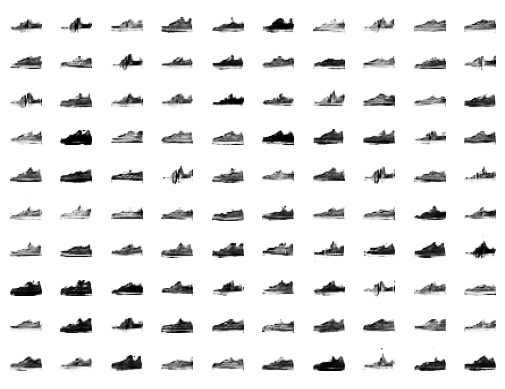

In [58]:

# example of loading the generator model and generating images
from math import sqrt
from numpy import asarray
from numpy.random import randn
from keras.models import load_model
from matplotlib import pyplot
 
# generate points in latent space as input for the generator
def generate_latent_points2(latent_dim, n_samples, n_class):
 # generate points in the latent space
 x_input = randn(latent_dim * n_samples)
 # reshape into a batch of inputs for the network
 z_input = x_input.reshape(n_samples, latent_dim)
 # generate labels
 labels = asarray([n_class for _ in range(n_samples)])
 return [z_input, labels]
 
# create and save a plot of generated images
def save_plot(examples, n_examples):
 # plot images
 for i in range(n_examples):
   # define subplot
   plt.subplot(sqrt(n_examples), sqrt(n_examples), 1 + i)
   # turn off axis
   plt.axis('off')
   # plot raw pixel data
   plt.imshow(examples[i, :, :, 0], cmap='gray_r')
 plt.show()
 
# load model
model = load_model('model_9370.h5')
latent_dim = 100
n_examples = 100 # must be a square
n_class = 7 # La clase, un sneaker
# generate images
latent_points, labels = generate_latent_points2(latent_dim, n_examples, n_class)
# generate images
X  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
save_plot(X, n_examples)

In [ ]:
# TO-DO AHORA HACEMOS Hola mundo con las letras obtenidas